In [10]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

# Block encoding with matrix access oracles

Prominent quantum algorithms such as quantum phase estimation and
quantum singular value transformation sometimes need to use
**non-unitary** matrices inside quantum circuits. This is problematic
because quantum computers can only perform unitary evolutions 🔥. Block
encoding is a technique that solves this problem by embedding a
non-unitary operator as a sub-block of a larger unitary matrix 🧯.

In previous demos we have discussed methods for
[simulator-friendly](https://pennylane.ai/qml/demos/tutorial_intro_qsvt#transforming-matrices-encoded-in-matrices)
encodings and block encodings using [linear combination of
unitaries](https://pennylane.ai/qml/demos/tutorial_lcu_blockencoding)
(LCU) decompositions. In this tutorial we explore another general block
encoding framework that can be very efficient for sparse and structured
matrices: block encoding with matrix access oracles.

![](../_static/demonstration_assets/block_encoding/thumbnail_Block_Encodings_Matrix_Oracle.png){.align-center
width="50.0%"}

A general circuit for block encoding an arbitrary matrix
$A \in \mathbb{C}^{N \times N}$ with $N = 2^{n}$ can be constructed as
shown in the figure below, if we have access to the oracles $U_A$ and
$U_B:$

![](../_static/demonstration_assets/block_encoding/general_circuit.png){.align-center
width="50.0%"}

Where the $H^{\otimes n}$ operation is a Hadamard transformation on $n$
qubits. The $U_A$ operation is an oracle which encodes the matrix
element $A_{i,j}$ into the the amplitude of the ancilla qubit. The $U_B$
oracle ensures that we iterate over every combination of $(i,j).$

Finding an optimal quantum gate decomposition that implements $U_A$ and
$U_B$ is not always possible. We now explore two different approaches
for constructing these oracles that can be very efficient for matrices
with specific structure or sparsity.

## Block encoding structured matrices

In order to better understand the oracle access framework, let us first
define $U_A$ and $U_B$ for the exact block-encoding of $A.$ The $U_A$
oracle is responsible for encoding the matrix entries of $A$ into the
amplitude of an auxilary qubit $|0\rangle_{\text{anc}}:$

$$U_A |0\rangle_{\text{anc}} |i\rangle |j\rangle = |A_{i,j}\rangle_{\text{anc}} |i\rangle |j\rangle,$$

where

$$|A_{i,j}\rangle_{\text{anc}} \equiv A_{i,j}|0\rangle_{\text{anc}} + \sqrt{1 - |A_{i,j}|^2}|1\rangle_{\text{anc}}.$$

The $U_B$ oracle is responsible for ensuring proper indexing of each
entry in $A$ and for this algorithm, it simplifies to be the
`~.pennylane.SWAP`{.interpreted-text role="class"} gate:

$$U_B |i\rangle|j\rangle \ = \ |j\rangle |i\rangle$$

The naive approach is to construct $U_A$ using a sequence of
multi-controlled $Ry(\alpha)$ rotation gates with rotation angles
computed as $\alpha = \text{arccos}(A_{i,j}).$ It turns out that this
requires $O(N^{4})$ gates and is very inefficient. A more efficient
approach is the Fast Approximate BLock Encodings (FABLE) technique,
which uses the oracle access framework and some clever approximations
🧠. The level of approximation in FABLE can be adjusted to simplify the
resulting circuit. For matrices with specific structures, FABLE provides
an efficient circuit *without* reducing accuracy.

The FABLE circuit is constructed from a set of single $Ry$ rotation and
C-NOT gates. We can remove the need for multi-controlled rotations using
a special transformation of the angles (see for details). The rotation
angles, $(\theta_1, ..., \theta_n),$ are obtained from a transformation
of the elements of the block-encoded matrix.

$$\begin{aligned}
\begin{pmatrix} \theta_1 \\ \cdots \\ \theta_n \end{pmatrix} =
M \begin{pmatrix} \alpha_1 \\ \cdots \\ \alpha_n \end{pmatrix}.
\end{aligned}$$

The angles $\alpha$ are obtained from the matrix elements of the matrix
$A$ as $\alpha_1 = \text{arccos}(A_{00}), ...,$ and $M$ is the
transformation matrix that can be obtained with the
`~.pennylane.templates.state_preparations.mottonen.compute_theta`{.interpreted-text
role="func"} function of PennyLane.

The `~.pennylane.FABLE`{.interpreted-text role="class"} circuit is
implemented in PennyLane and can be easily used to block encode matrices
of any given shape. Here, we manually construct the circuit for a
structured $4 \times 4$ matrix.


In [ ]:
import pennylane as qml
from pennylane.templates.state_preparations.mottonen import compute_theta, gray_code
import numpy as np
import matplotlib.pyplot as plt


def A_matrix(n):
    N = 2**n
    A = np.zeros((N, N))
    A += np.diag(np.ones(N - 1), k=1)
    A -= np.diag(np.ones(N - 1), k=-1)
    A[0, -1] = -1
    A[-1, 0] = 1
    return A


A = A_matrix(3)

print(A)
# A = np.array([[-0.51192128, -0.51192128,  0.6237114 ,  0.6237114 ],
#               [ 0.97041007,  0.97041007,  0.99999329,  0.99999329],
#               [ 0.82429855,  0.82429855,  0.98175843,  0.98175843],
#               [ 0.99675093,  0.99675093,  0.83514837,  0.83514837]])

[[ 0.  1.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  1.]
 [ 1.  0.  0.  0.  0.  0. -1.  0.]]


We also compute the rotation angles.


In [12]:
alphas = np.arccos(A).flatten()
thetas = compute_theta(alphas)

The next step is to identify and prepare the qubit registers used in the
oracle access framework. There are three registers `"ancilla"`,
`"wires_i"`, `"wires_j"`. The `"ancilla"` register will always contain a
single qubit, this is the auxilary qubit where we apply the rotation
gates mentioned above. The `"wires_i"` and `"wires_j"` registers are the
same size for this algorithm and need to be able to encode $A$ itself,
so they will both have $2$ qubits for our matrix.


In [13]:
ancilla_wires = ["ancilla"]

s = int(np.log2(A.shape[0]))
wires_i = [f"i{index}" for index in range(s)]
wires_j = [f"j{index}" for index in range(s)]

Finally, we obtain the control wires for the C-NOT gates and a wire map
that we later use to translate the control wires into the wire registers
we prepared.


In [14]:
code = gray_code(2 * np.log2(len(A)))
n_selections = len(code)

control_wires = [int(np.log2(int(code[i], 2) ^ int(code[(i + 1) % n_selections], 2))) for i in range(n_selections)]

wire_map = {control_index: wire for control_index, wire in enumerate(wires_j + wires_i)}

In [16]:
wire_map

{0: 'j0', 1: 'j1', 2: 'j2', 3: 'i0', 4: 'i1', 5: 'i2'}

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

s = 2
qr1 = QuantumRegister(s, name="Q1")
qr2 = QuantumRegister(s, name="Q2")
qc = QuantumCircuit(qr1, qr2, name="U")

qr1_map = [qr1[i] for i in range(s)]
qr2_map = [qr2[i] for i in range(s)]
total_map = qr1_map + qr2_map

wire_map = {control_index: wire for control_index, wire in enumerate(total_map)}

In [26]:
wire_map

{0: Qubit(QuantumRegister(2, 'Q1'), 0),
 1: Qubit(QuantumRegister(2, 'Q1'), 1),
 2: Qubit(QuantumRegister(2, 'Q2'), 0),
 3: Qubit(QuantumRegister(2, 'Q2'), 1)}

We now construct the $U_A$ and $U_B$ oracles as well as the operator
representing the tensor product of Hadamard gates.


In [7]:
def UA(thetas, control_wires, ancilla):
    for theta, control_index in zip(thetas, control_wires):
        qml.RY(2 * theta, wires=ancilla)
        qml.CNOT(wires=[wire_map[control_index]] + ancilla)


def UB(wires_i, wires_j):
    for w_i, w_j in zip(wires_i, wires_j):
        qml.SWAP(wires=[w_i, w_j])


def HN(input_wires):
    for w in input_wires:
        qml.Hadamard(wires=w)

We construct the circuit using these oracles and draw it.


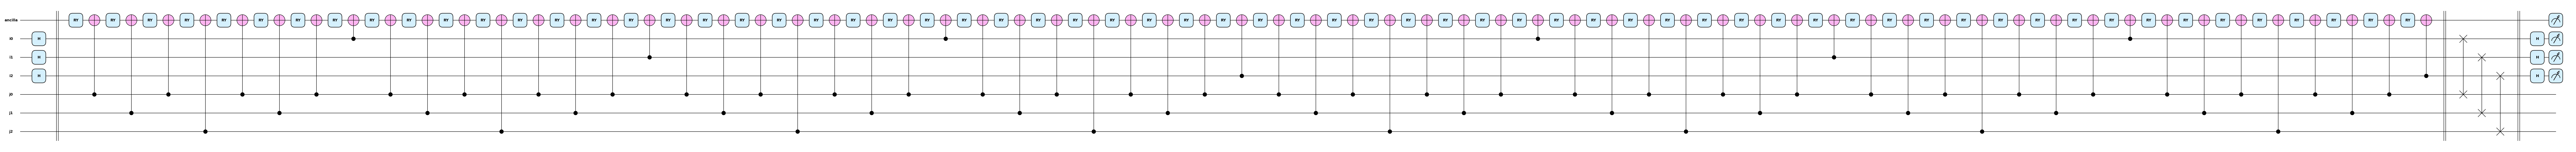

In [8]:
dev = qml.device("default.qubit", wires=ancilla_wires + wires_i + wires_j)


@qml.qnode(dev)
def circuit():
    HN(wires_i)
    qml.Barrier()  # to separate the sections in the circuit
    UA(thetas, control_wires, ancilla_wires)
    qml.Barrier()
    UB(wires_i, wires_j)
    qml.Barrier()
    HN(wires_i)
    return qml.probs(wires=ancilla_wires + wires_i)


qml.draw_mpl(circuit, style="pennylane")()
plt.show()

Finally, we compute the matrix representation of the circuit and print
its top-left block to compare it with the original matrix.


In [9]:
print(f"Original matrix:\n{A}", "\n")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
M = len(A) * qml.matrix(circuit, wire_order=wire_order)().real[0 : len(A), 0 : len(A)]
print(f"Block-encoded matrix:\n{M}", "\n")

Original matrix:
[[ 0.  1.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  1.]
 [ 1.  0.  0.  0.  0.  0. -1.  0.]] 

Block-encoded matrix:
[[ 1.82370455e-16  1.00000000e+00 -5.89928756e-17 -4.44727991e-16
   1.34251793e-16  2.11247972e-16  3.39825361e-17 -1.00000000e+00]
 [-1.00000000e+00  6.46135205e-17  1.00000000e+00 -2.89981411e-16
   2.11247972e-16  5.65013923e-17  3.39825361e-17 -2.88657283e-16]
 [ 1.21108486e-16 -1.00000000e+00 -1.97405642e-17  1.00000000e+00
   1.32743349e-16  1.80033030e-17  2.53612090e-17  6.46135205e-17]
 [ 2.69496405e-16  1.03865832e-16 -1.00000000e+00 -2.90735634e-16
   1.00000000e+00 -2.04947863e-17 -8.37743983e-17 -2.01531333e-16]
 [ 1.34251793e-16  2.11247972e-16  3.39825361e-17 -1.00000000e+00
   1.82370455e-16  1.00000000e+00 -5.89928756e-17 -4.44727991e-16]
 [ 2.11247972

You can easily confirm that the circuit block encodes the original
matrix defined above. Note that the dimension of $A$ should be $2^n$
where $n$ is an integer. For matrices with an arbitrary size, we can add
zeros to reach the correct dimension. The padding will be automatically
applied in `~.pennylane.FABLE`{.interpreted-text role="class"}
implemented in PennyLane.

The interesting point about the FABLE method is that we can eliminate
those rotation gates that have an angle smaller than a defined
threshold. This leaves a sequence of C-NOT gates that in most cases
cancel each other out. You can confirm that two C-NOT gates applied to
the same wires cancel each other. Let\'s now remove all the rotation
gates that have an angle smaller than $0.01$ and draw the circuit.


In [ ]:
tolerance = 0.01


def UA(thetas, control_wires, ancilla):
    for theta, control_index in zip(thetas, control_wires):
        if abs(2 * theta) > tolerance:
            qml.RY(2 * theta, wires=ancilla)
        qml.CNOT(wires=[wire_map[control_index]] + ancilla)


qml.draw_mpl(circuit, style="pennylane")()
plt.show()

Compressing the circuit by removing some of the rotations is an
approximation. We can now remove the C-NOT gates that cancel each other
out and see how good this approximation is in the case of our example.
We will make a small modification to $U_A$ so that it removes those
C-NOT gates that cancel each other out.


In [ ]:
def UA(thetas, control_wires, ancilla):
    nots = []
    for theta, control_index in zip(thetas, control_wires):
        if abs(2 * theta) > tolerance:
            for c_wire in nots:
                qml.CNOT(wires=[c_wire] + ancilla)
            qml.RY(2 * theta, wires=ancilla)
            nots = []
        if (cw := wire_map[control_index]) in nots:
            del nots[nots.index(cw)]
        else:
            nots.append(wire_map[control_index])
    for c_wire in nots:
        qml.CNOT([c_wire] + ancilla)


qml.draw_mpl(circuit, style="pennylane")()
plt.show()

print(f"Original matrix:\n{A}", "\n")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
M = len(A) * qml.matrix(circuit, wire_order=wire_order)().real[0 : len(A), 0 : len(A)]
print(f"Block-encoded matrix:\n{M}", "\n")

You can see that the compressed circuit is equivalent to the original
circuit. This happens because our original matrix is highly structured
and many of the rotation angles are zero. However, this is not always
true for an arbitrary matrix. Can you construct another matrix that
allows a significant compression of the block encoding circuit without
affecting the accuracy?

# Block encoding sparse matrices

The quantum circuit for the oracle $U_A,$ presented above, accesses
every entry of $A$ and thus requires $~ O(N^2)$ gates to implement the
oracle. In the special cases where $A$ is structured and sparse, we can
generate a more efficient quantum circuit representation for $U_A$ and
$U_B$ by only keeping track of the non-zero entries of the matrix.

Let $b(i,j)$ be a function such that it takes a column index $j$ and
returns the row index for the $i^{th}$ non-zero entry in that column of
$A.$ Note, in this formulation, the $|i\rangle$ qubit register now
refers to the number of non-zero entries in $A.$ For sparse matrices,
this can be much smaller than $N,$ thus saving us many qubits. We use
this to define $U_A$ and $U_B.$

Like in the structured approach, the $U_A$ oracle is responsible for
encoding the matrix entries of $A$ into the amplitude of the ancilla
qubit. However, we now use $b(i,j)$ to access the row index of the
non-zero entries:

$$U_A |0\rangle_{\text{anc}} |i\rangle |j\rangle = |A_{b(i,j),j}\rangle_{\text{anc}} |i\rangle |j\rangle,$$

In this case the $U_B$ oracle is responsible for implementing the
$b(i,j)$ function and taking us from the column index to the row index
in the qubit register:

$$U_B |i\rangle|j\rangle \ = \ |i\rangle |b(i,j)\rangle$$

Let\'s work through an example. Consider the sparse matrix given by:

$$\begin{aligned}
A = \begin{bmatrix}
\alpha & \gamma & 0 & \dots & \beta\\
\beta & \alpha & \gamma & \ddots & 0 \\
0 & \beta & \alpha & \gamma \ddots & 0\\
0 & \ddots & \beta & \alpha & \gamma\\
\gamma & 0 & \dots & \beta & \alpha \\
\end{bmatrix},
\end{aligned}$$

where $\alpha,$ $\beta$ and $\gamma$ are real numbers. The following
code block prepares the matrix representation of $A$ for an $8 \times 8$
sparse matrix.


In [ ]:
alpha, beta, gamma = 0.1, 0.6, 0.3

A = np.array(
    [
        [alpha, gamma, 0, 0, 0, 0, 0, beta],
        [beta, alpha, gamma, 0, 0, 0, 0, 0],
        [0, beta, alpha, gamma, 0, 0, 0, 0],
        [0, 0, beta, alpha, gamma, 0, 0, 0],
        [0, 0, 0, beta, alpha, gamma, 0, 0],
        [0, 0, 0, 0, beta, alpha, gamma, 0],
        [0, 0, 0, 0, 0, beta, alpha, gamma],
        [gamma, 0, 0, 0, 0, 0, beta, alpha],
    ]
)

print(f"Original A:\n{A}", "\n")

Once again we identify and prepare the qubit registers used in the
oracle access framework.

The `"ancilla"` register will still contain a single qubit, the target
for the controlled rotation gates. The `"wires_i"` register needs to be
large enough to binary encode the maximum number of non-zero entries in
any column or row. Given the structure of $A$ defined above, we have at
most 3 non-zero entries, thus this register will have 2 qubits. Finally,
the `"wires_j"` register will be used to encode $A$ itself, so it will
have 3 qubits. We prepare the wires below:


In [ ]:
s = int(np.log2(A.shape[0]))  # number of qubits needed to encode A

ancilla_wires = ["ancilla"]  # always 1 qubit for controlled rotations
wires_i = ["i0", "i1"]  # depends on the sparse structure of A
wires_j = [f"j{index}" for index in range(s)]  # depends on the size of A

The $U_A$ oracle for this matrix is constructed from controlled rotation
gates, similar to the FABLE circuit.


In [ ]:
def UA(theta, wire_i, ancilla):
    qml.ctrl(qml.RY, control=wire_i, control_values=[0, 0])(theta[0], wires=ancilla)
    qml.ctrl(qml.RY, control=wire_i, control_values=[1, 0])(theta[1], wires=ancilla)
    qml.ctrl(qml.RY, control=wire_i, control_values=[0, 1])(theta[2], wires=ancilla)

The $U_B$ oracle is defined in terms of the so-called `Left` and `Right`
shift operators. They correspond to the modular arithmetic operations
$+1$ or $-1$ respectively.


In [ ]:
def shift_op(s_wires, shift="Left"):
    for index in range(len(s_wires) - 1, 0, -1):
        control_values = [1] * index if shift == "Left" else [0] * index
        qml.ctrl(qml.PauliX, control=s_wires[:index], control_values=control_values)(wires=s_wires[index])
    qml.PauliX(s_wires[0])


def UB(wires_i, wires_j):
    qml.ctrl(shift_op, control=wires_i[0])(wires_j, shift="Left")
    qml.ctrl(shift_op, control=wires_i[1])(wires_j, shift="Right")

We now construct our circuit to block encode the sparse matrix and draw
it.


In [ ]:
dev = qml.device("default.qubit", wires=(ancilla_wires + wires_i + wires_j))


@qml.qnode(dev)
def complete_circuit(thetas):
    HN(wires_i)
    qml.Barrier()  # to separate the sections in the circuit
    UA(thetas, wires_i, ancilla_wires)
    qml.Barrier()
    UB(wires_i, wires_j)
    qml.Barrier()
    HN(wires_i)
    return qml.probs(wires=ancilla_wires + wires_i)


s = 4  # normalization constant
thetas = 2 * np.arccos(np.array([alpha - 1, beta, gamma]))

qml.draw_mpl(complete_circuit, style="pennylane")(thetas)
plt.show()

Finally, we compute the matrix representation of the circuit and print
its top-left block to compare it with the original matrix.


In [ ]:
print("\nBlockEncoded Mat:")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
mat = qml.matrix(complete_circuit, wire_order=wire_order)(thetas).real[: len(A), : len(A)] * s
print(mat, "\n")

You can confirm that the circuit block encodes the original sparse
matrix defined above. Note that if we wanted to increase the dimension
of $A$ (for example $16 \times 16$), then we need only to add more wires
to the `j` register in the device and in `UB`.

# Conclusion

Block encoding is a powerful technique in quantum computing that allows
us to implement a non-unitary operation in a quantum circuit by
embedding the operation in a larger unitary gate. In this tutorial, we
reviewed two important block encoding methods with code examples using
PennyLane. This allows you to use PennyLane to explore and benchmark
several block encoding approaches for a desired problem. The efficiency
of the block encoding methods typically depends on the sparsity and
structure of the original matrix. We hope that you can use these tips
and tricks to find a more efficient block encoding for your matrix!

# References


# About the author
